In [7]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [8]:
dataroot = Path("./assets/preprocessed")
train_path = dataroot / "Train_nus-wide.ndjson"
test_path = dataroot / "Test_nus-wide.ndjson"

In [9]:
test = pl.read_ndjson(test_path)
train = pl.read_ndjson(train_path)

test = set(test["file_name"])
train = set(train["file_name"])
test.intersection(train)

set()

In [10]:
train = pl.read_ndjson(train_path)
test = pl.read_ndjson(test_path)

train.count(), test.count()

(shape: (1, 4)
 ┌───────────┬────────┬────────┬────────────┐
 │ file_name ┆ labels ┆ tags   ┆ image_root │
 │ ---       ┆ ---    ┆ ---    ┆ ---        │
 │ u32       ┆ u32    ┆ u32    ┆ u32        │
 ╞═══════════╪════════╪════════╪════════════╡
 │ 121962    ┆ 121962 ┆ 121962 ┆ 121962     │
 └───────────┴────────┴────────┴────────────┘,
 shape: (1, 4)
 ┌───────────┬────────┬───────┬────────────┐
 │ file_name ┆ labels ┆ tags  ┆ image_root │
 │ ---       ┆ ---    ┆ ---   ┆ ---        │
 │ u32       ┆ u32    ┆ u32   ┆ u32        │
 ╞═══════════╪════════╪═══════╪════════════╡
 │ 81636     ┆ 81636  ┆ 81636 ┆ 81636      │
 └───────────┴────────┴───────┴────────────┘)

Train values
Mean 2.42 | Std 1.59 | Median 2.0
Max 12 | Min 1
Test values
Mean 2.43 | Std 1.59 | Median 2.0
Max 13 | Min 1


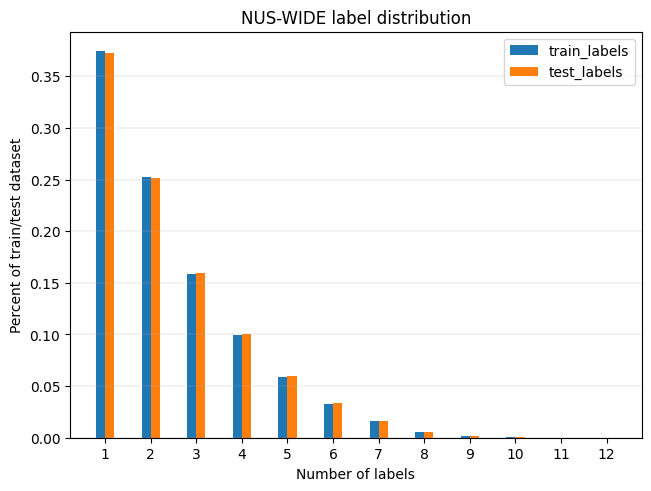

In [11]:
# Calculating norm for LQP training
train = pl.read_ndjson(train_path)
test = pl.read_ndjson(test_path)

train = train.with_columns(
    pl.col("labels").list.len().alias("n_train"),
)
test = test.with_columns(
    pl.col("labels").list.len().alias("n_test"),
)

train_label_counts = train.select(
    pl.col("n_train").value_counts()
).unnest("n_train").sort("n_train")
test_label_counts = test.select(
    pl.col("n_test").value_counts()
).unnest("n_test").sort("n_test")

train_mean = train["n_train"].mean()
train_median = train["n_train"].median()
train_std = train["n_train"].std()
train_maximum = train["n_train"].max()
train_minimum = train["n_train"].min()

test_mean = test["n_test"].mean()
test_median = test["n_test"].median()
test_std = test["n_test"].std()
test_maximum = test["n_test"].max()
test_minimum = test["n_test"].min()

train_count = 121962
test_count = 81636

x = train_label_counts["n_train"]
width = 0.2 
multiplier = 0

distribution = {
    "train_labels": train_label_counts["count"] / train_count,
    "test_labels": test_label_counts["count"] / test_count,
}

fig, ax = plt.subplots(layout="constrained")
ax.set_xticks(x + width, x)
ax.set_ylabel("Percent of train/test dataset")
ax.set_xlabel("Number of labels")

for attribute, measurement in distribution.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, align="edge")
    multiplier += 1

print("Train values")
print(f"Mean {train_mean:.2f} | Std {train_std:.2f} | Median {train_median}")
print(f"Max {train_maximum} | Min {train_minimum}")
print("Test values")
print(f"Mean {test_mean:.2f} | Std {test_std:.2f} | Median {test_median}")
print(f"Max {test_maximum} | Min {test_minimum}")
plt.grid(axis="y", linewidth=0.2)
plt.title("NUS-WIDE label distribution")
plt.legend()
plt.show()

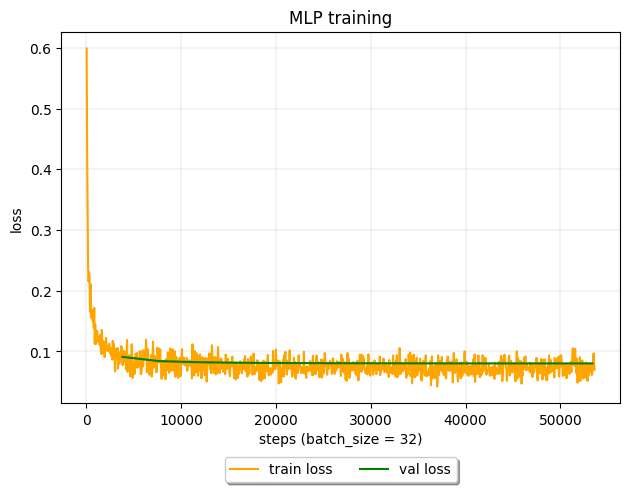

In [12]:
root = Path("./assets/trained_models")
model_root = "mlp.train"
train_progress_path = root / model_root / "metrics.csv"

prog = pl.read_csv(train_progress_path)
train_loss = (
    prog
    .filter(~pl.col("train_loss").is_null())
    .select(pl.col("step").cast(pl.Int64), pl.col("train_loss").cast(pl.Float64))
)
val_loss = (
    prog
    .filter(~pl.col("val_loss").is_null())
    .select(pl.col("step").cast(pl.Int64), pl.col("val_loss").cast(pl.Float64))
)
#hf1_score = (
#    prog
#    .filter(~pl.col("H_F1").is_null())
#    .select(pl.col("step").cast(pl.Int64), pl.col("H_F1").cast(pl.Float64))
#)

fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("steps (batch_size = 32)")
ax1.set_ylabel("loss")
ax1.plot(train_loss["step"], train_loss["train_loss"], color="orange", label="train loss")
ax1.plot(val_loss["step"], val_loss["val_loss"], color="green", label="val loss")
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.125), fancybox=True, shadow=True, ncol=5)

#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = "tab:blue"
#ax2.set_ylabel("H_F1", color=color)  # we already handled the x-label with ax1
#ax2.plot(hf1_score["step"], hf1_score["H_F1"], color=color, label="H_F1 score")
#ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("MLP training")
plt.grid(linewidth=0.2)
plt.show()